# Emperically Estimate: Hetro GP

When the outcome of an action is stocastic, can we using GP, figure out its randomness.

## Lessons
1. Objective function must be smooth 
2. Careful about the design

## Synthetic Example: Single Basin with Stocastic Inflows

In [34]:
import baestorm
import GPy
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyswmm_lite import environment
plt.style.use('dark_background')
plt.rcParams["figure.figsize"] = (12,7)
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['lines.linewidth'] = 4.0
plt.rcParams['font.size'] = 18.0
plt.rcParams['font.sans-serif'] = 'Helvetica'

### Generate Inflows

Inflows to the system are gaussian, with variance between 1.0-3.0 at 0.0 mean. 

In [3]:
def gaussian_flows(x, mu=0.0, sigma=1.0):
    y = (1.0/(sigma*(np.sqrt(2.0*np.pi)))) * np.exp(-0.5*((x-mu)/sigma)**2)
    return y
gaussian_flows = np.vectorize(gaussian_flows)

In [249]:
means = [0.0]
sigma = np.linspace(2.0, 5.0, 10)
scale = 5.0

inflows = {}
count = 0
for mu in means:
    for sig in sigma:
        inflows[str(count)] = scale * gaussian_flows(np.linspace(-10.0, 10.0, 100), mu, sig)
        count += 1
inflows = pd.DataFrame.from_dict(inflows)

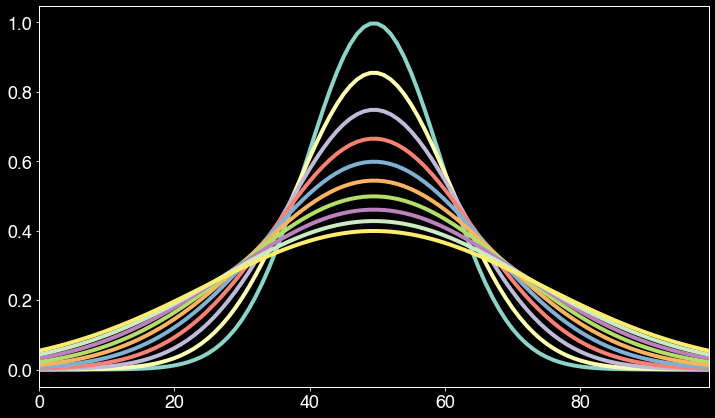

In [250]:
inflows.plot(legend=False)

### Basin Response:

Observe the basin response and find a appropriate threshold.

In [251]:
def single_basin(actions, flows):
    env = environment(baestorm.load_networks("parallel"), False)

    data = {}
    data["outflow"] = []
    data["overflow"] = []
    
    # pad inflows, so that the systems receds
    flows = np.append(flows, np.zeros(300))
    
    for time in range(0, len(flows)):
        # set the gate_position
        env._setValvePosition("1", actions)

        env.sim._model.setNodeInflow("P1", 3 * flows[time])
        env.sim._model.setNodeInflow("P2", 0.0)

        # record_data
        data["outflow"].append(env._getLinkFlow("1"))
        data["overflow"].append(env.sim._model.getNodeResult("P1", 4))

        # step through simulation
        _ = env.step()
    env._terminate()
    return data["outflow"], sum(data["overflow"])

In [252]:
data_flows = {}
for i in inflows.keys():
    flows, _  = single_basin(1.0, inflows[i].values)
    data_flows[i] = flows
data_flows = pd.DataFrame.from_dict(data_flows)

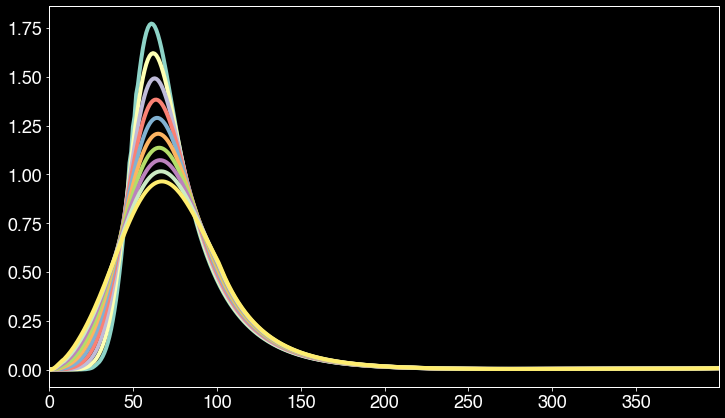

In [253]:
data_flows.plot(legend=False)

Looks like 0.60 might be a decent threshold.

### Design the objective function

In [254]:
def objective_function(x):
    valves = x[0][0]
    # Sample a random inflow
    temp_1 = np.random.choice(np.linspace(0, 9, 10, dtype=int))
    # Simulate and generate flow transformations 
    flows, overflows = single_basin(valves, inflows[str(temp_1)].values)
    # Convert to pandas series for ease of ops
    flows = pd.Series(flows)
    overflows = pd.Series(overflows)
    # Compute performance
    reward = 0.0
    overflows = overflows.sum()
    # Easire reward 
    if overflows>0.0:
        reward += 30.0*overflows
    flows = flows.sub(0.60)
    flows[flows < 0.0] = 0.0
    reward += 10.0*flows.sum()
    return reward

#### Check the objective function

Take an action for 20 times and look at the response.

In [280]:
actions = np.linspace(0.1, 1.0, 100)
reward = np.zeros((20, 100))
for action in range(0, 100):
    for rainevent in range(0, 20):
        reward[rainevent, action] = objective_function(actions[action].reshape(-1,1))

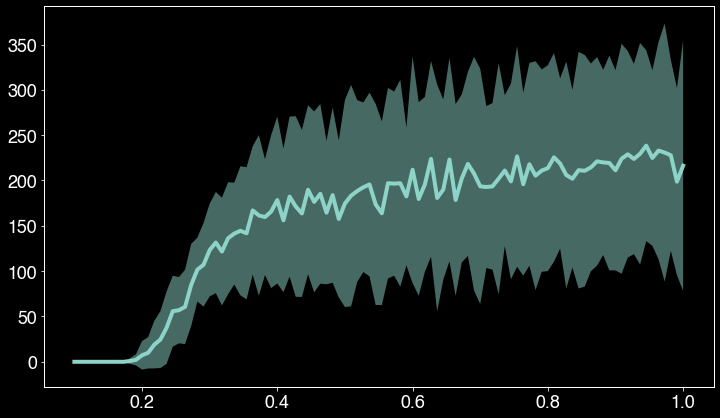

In [282]:
m = reward.mean(axis=0)
std = np.std(reward, 0)
up = m + 2.0 * std
dwn = m - 2.0 * std
plt.plot(actions, reward.mean(axis=0))
plt.fill_between(actions, up, dwn, alpha=0.5)

Looks convex enough. 

## Generate data for GP using random sampling

In [402]:
x = []
y = []
for j in range(0,3):
    val = np.linspace(0.0,1.0,100)
    for i in range(0, 100):
        x_t = np.array(val[i]) # random action between 0 to 1
        y_t = objective_function(x_t.reshape(-1,1))
        x.append(x_t)
        y.append(y_t)

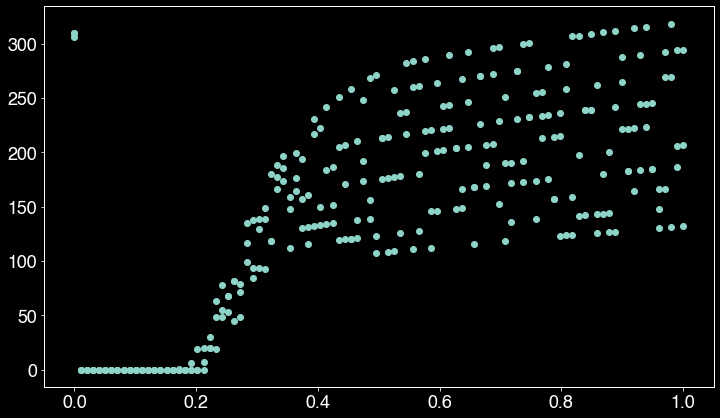

In [403]:
plt.plot(x, y, 'o')

### Normalize the data so that we dont end up with weird things

In [364]:
y = np.array(y)
x = np.array(x)

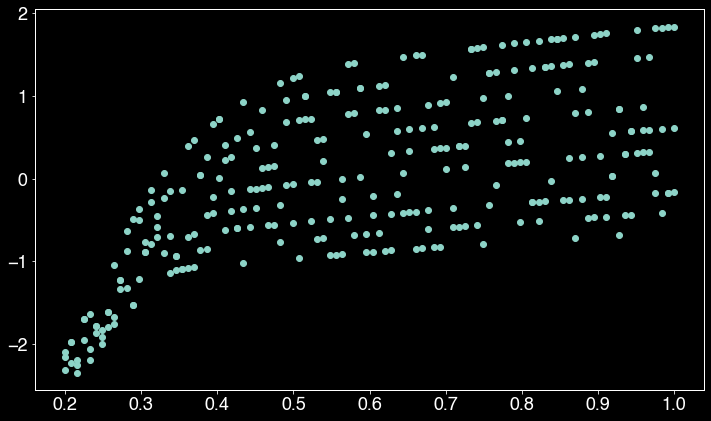

In [365]:
y = (y - y.mean())/y.std()
plt.plot(x, y, 'o')

## Gaussian Processes

Lets train GP to learn on this data

Optimization restart 1/10, f = 323.8281070616256
Optimization restart 2/10, f = 323.82810707565915
Optimization restart 3/10, f = 323.8281070582823
Optimization restart 4/10, f = 323.8281070565728
Optimization restart 5/10, f = 323.82810705650127
Optimization restart 6/10, f = 323.82810708682155
Optimization restart 7/10, f = 323.8281070565981
Optimization restart 8/10, f = 323.82810705993705
Optimization restart 9/10, f = 323.82810705654623
Optimization restart 10/10, f = 323.8281070569285


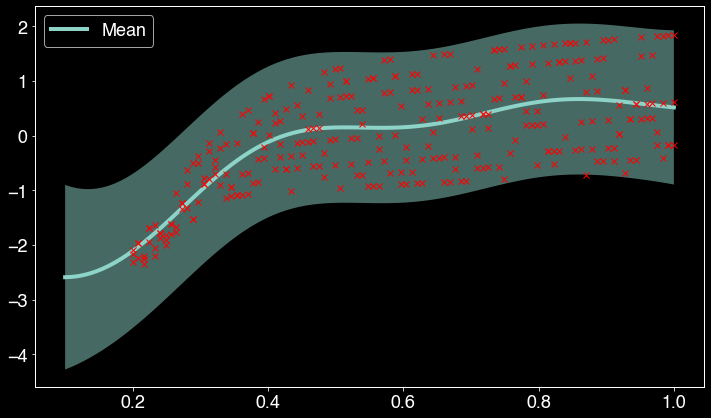

In [366]:
kernel_vgp = GPy.kern.RBF(input_dim=1) + GPy.kern.White(input_dim=1)
vgp = GPy.models.GPRegression(x.reshape(-1,1), y.reshape(-1,1), kernel_vgp)
vgp.optimize(messages=False)
vgp.optimize_restarts(num_restarts = 10)
# Plot error bounds
x_test = np.linspace(0.1,1.0, 100)
m, v = vgp.predict(x_test.reshape(-1,1))
up = m.reshape(-1) + 2.0*np.sqrt(v.reshape(-1))
dwn = m.reshape(-1) - 2.0*np.sqrt(v.reshape(-1))

plt.fill_between(x_test, up, dwn, alpha=0.5)
plt.plot(x_test, m, label="Mean")
plt.legend()
plt.plot(x,y,'x',color='red')

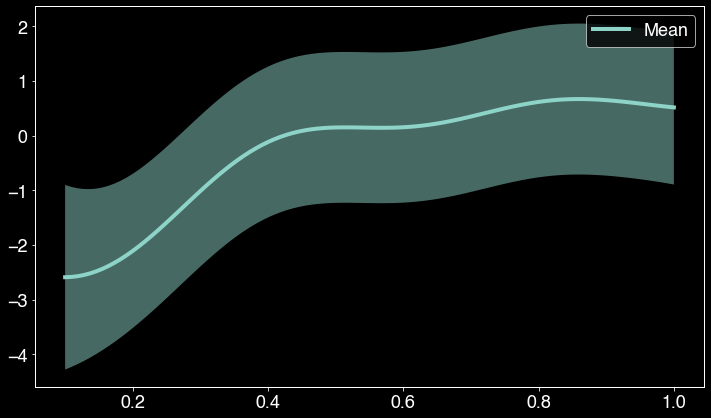

In [367]:
plt.fill_between(x_test, up, dwn, alpha=0.5)
plt.plot(x_test, m, label="Mean")
plt.legend()

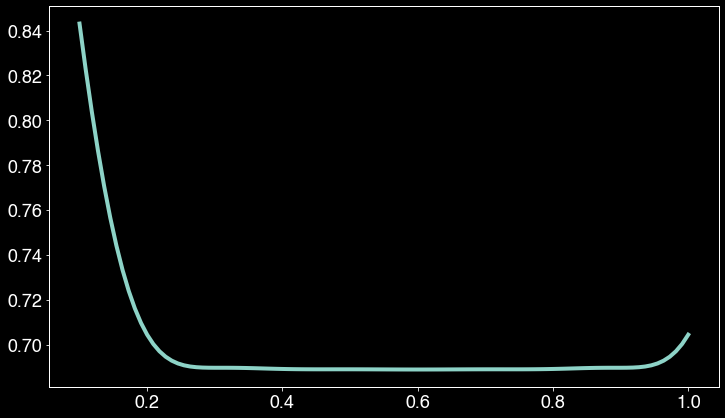

In [368]:
plt.plot(x_test, np.sqrt(v))

Mean looks right, but the variance is over estimated.

## Hetro GP

In [369]:
# RBF and WhiteNoise kernel
kernel1 = GPy.kern.RBF(input_dim=1) + GPy.kern.White(input_dim=1)
gp1 = GPy.models.GPRegression(x.reshape(-1,1),y.reshape(-1,1),kernel1)
gp1.optimize(messages=False)
gp1.optimize_restarts(num_restarts = 5)

Optimization restart 1/5, f = 323.8281070616256
Optimization restart 2/5, f = 323.8281070565729
Optimization restart 3/5, f = 323.8281070566014
Optimization restart 4/5, f = 323.8281070862598
Optimization restart 5/5, f = 323.82810706494206


In [393]:
m, v = gp1.predict(x.reshape(-1,1))
s = 25
variance_noise = np.zeros(len(x))
for j in range(0, len(x)):
    var = 0.0
    for i in range(0, s):
        var += 0.5 * (y[j] - np.random.normal(m[j], v[j]))**2
    variance_noise[j] = var/s
z = np.log(variance_noise)
#mean_z = z.mean()
#std_z = z.std()

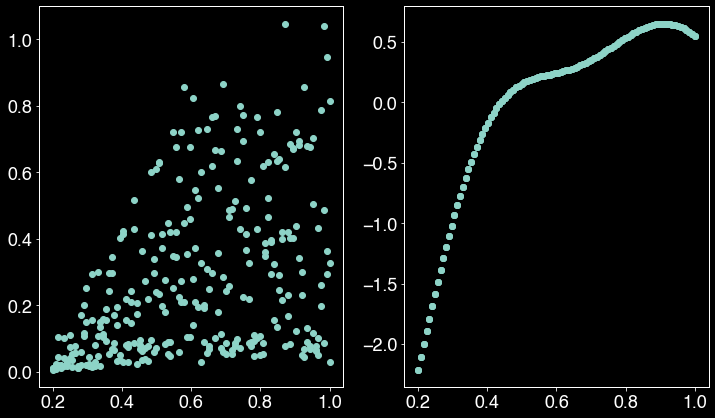

In [394]:
plt.subplot(1,2,1)
plt.plot(x, variance_noise,'o')
plt.subplot(1,2,2)
plt.plot(x, m,'o')

In [395]:
kernel2 = GPy.kern.RBF(input_dim=1) + GPy.kern.White(input_dim=1)
gp2 = GPy.models.GPRegression(x.reshape(-1,1),z.reshape(-1,1),kernel2)
gp2.optimize(messages=False)
gp2.optimize_restarts(num_restarts = 10)
m_n, v_n = gp2.predict(x.reshape(-1,1))

Optimization restart 1/10, f = 409.5285227536063
Optimization restart 2/10, f = 409.5285227536122
Optimization restart 3/10, f = 409.52852275360505
Optimization restart 4/10, f = 409.5285227579095
Optimization restart 5/10, f = 409.5285228007163
Optimization restart 6/10, f = 409.5285227536292
Optimization restart 7/10, f = 409.52852275618557
Optimization restart 8/10, f = 409.52852275360425
Optimization restart 9/10, f = 409.52852275594427
Optimization restart 10/10, f = 409.5285237986334


In [396]:
kernel2

sum.,value,constraints,priors
rbf.variance,14.368579603989986,+ve,
rbf.lengthscale,0.5193809570020834,+ve,
white.variance,0.41412357801477434,+ve,


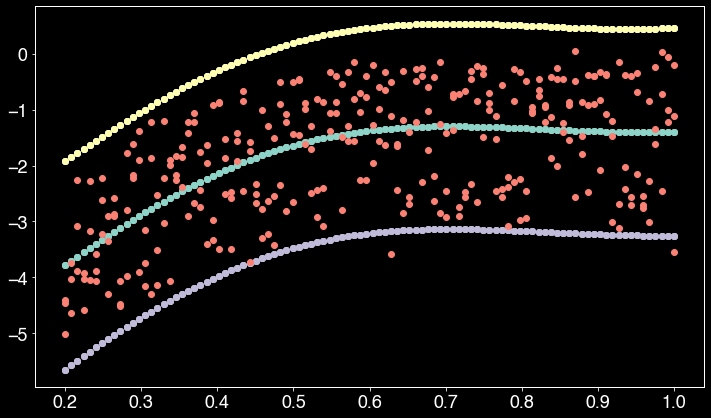

In [397]:
plt.plot(x, m_n, 'o')
up = m_n.reshape(-1) + 2.0*np.sqrt(v_n.reshape(-1))
dwn = m_n.reshape(-1) - 2.0*np.sqrt(v_n.reshape(-1))
plt.plot(x, up, 'o')
plt.plot(x, dwn, 'o')
plt.plot(x, (z), 'o')

In [404]:
kernel3 = GPy.kern.RBF(input_dim=1) + GPy.kern.WhiteHeteroscedastic(input_dim=1, num_data=x.shape[0])
gp3 = GPy.models.GPRegression(x.reshape(-1,1),y.reshape(-1,1),kernel3)
gp3.optimize(messages=False)
gp3.optimize_restarts(num_restarts = 10)

AttributeError: 'list' object has no attribute 'shape'

In [399]:
kernel3.parts[1].variance = np.exp(m_n).reshape(x.shape[0])

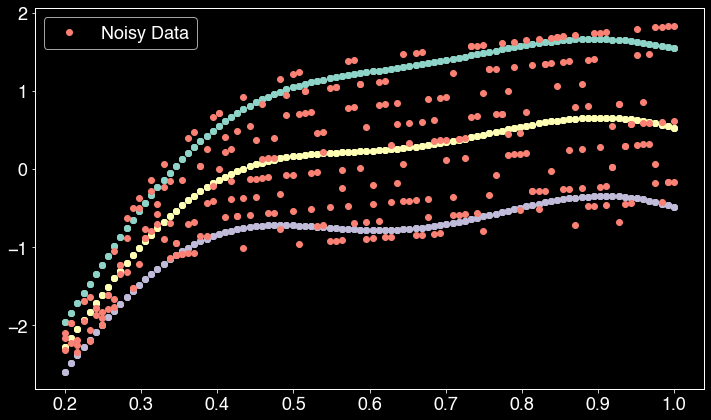

In [400]:
m, v = gp3.predict(x.reshape(-1,1))
up = m.reshape(-1) + 2.0*np.sqrt(v.reshape(-1))
dwn = m.reshape(-1) - 2.0*np.sqrt(v.reshape(-1))
plt.plot(x, up, 'o')
plt.plot(x, m, 'o')
plt.plot(x, dwn, 'o')
plt.plot(x, y, 'o', label="Noisy Data")
plt.legend()

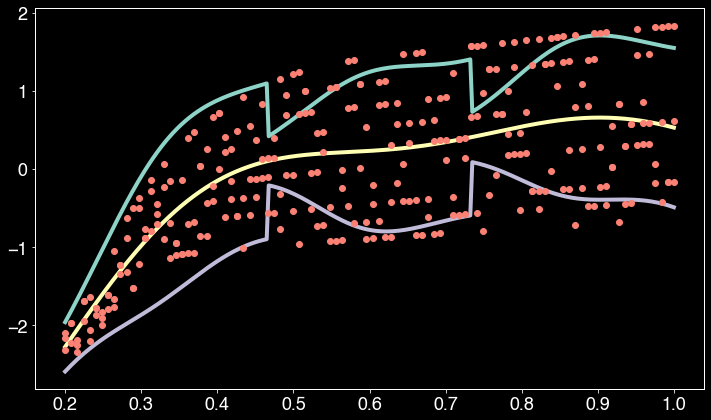

In [401]:
x_t = np.linspace(0.2, 1.0, 300)
m, v = gp3.predict(x_t.reshape(-1,1))
up = m.reshape(-1) + 2.0*np.sqrt(v.reshape(-1))
dwn = m.reshape(-1) - 2.0*np.sqrt(v.reshape(-1))
plt.plot(x_t, up)
plt.plot(x_t, m)
plt.plot(x_t, dwn)
plt.plot(x, y, 'o', label="Noisy Data")

In [392]:
gp1 = copy.deepcopy(gp3)

Here is the tricky part. Noise is dependent on action. But it is not exactly dependent on just the action, hence the difference between 0.5 to 0.6 (two valve positions) might not be the variables to map noise. We might be better of estimating the noise using a common one. Also the reward function has to be smooth. Any hard jumps in the design would cause trouble.

## Noise dependency

May be we try it with two variables, one with action and one with which rainfall us used, then learn the mapping between both and noise.